<a href="https://colab.research.google.com/github/cc-ca/Human_action_understanding/blob/clip/Clip_Action_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

TODO : 
- delete frames after we used them
- print only the name of the class
- calculate accuracy with validation test
- use more frame to predict the action

# Using CLIP to classify photos of people

This notebook presents classification of famous people from Russia (mostly politicians) based on CLIP zero-short transfer learning capabilities.



# Download and Install CLIP Dependencies

> Indented block

In [ ]:
# installing some dependencies, CLIP was released in PyTorch
import subprocess

CUDA_version = [s for s in subprocess.check_output(["nvcc", "--version"]).decode("UTF-8").split(", ") if s.startswith("release")][0].split(" ")[-1]
print("CUDA version:", CUDA_version)

if CUDA_version == "10.0":
    torch_version_suffix = "+cu100"
elif CUDA_version == "10.1":
    torch_version_suffix = "+cu101"
elif CUDA_version == "10.2":
    torch_version_suffix = ""
else:
    torch_version_suffix = "+cu110"

!pip install torch==1.7.1{torch_version_suffix} torchvision==0.8.2{torch_version_suffix} -f https://download.pytorch.org/whl/torch_stable.html ftfy regex

import numpy as np
import torch

print("Torch version:", torch.__version__)

CUDA version: 11.8
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.pytorch.org/whl/torch_stable.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 GB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 31.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 KB 5.4 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 1.13.1+cu116
    Uninstalling torch-1.13.1+cu116:
      Successfully uninstalled torch-1.13.1+cu116
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.14.1+cu116
    Uninstalling torchvision-0.14.1+cu116:
      Successfully uninstalled torchvision-0.14.1+cu116
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtext 0.14.1 requires torch==1.13

In [ ]:
!pip install gdown

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# clone the CLIP repository
!git clone https://github.com/openai/CLIP.git

import sys
from pathlib import Path

clip_dir = Path(".").absolute() / "CLIP"
sys.path.append(str(clip_dir))
print(f"CLIP dir is: {clip_dir}")

import clip

Cloning into 'CLIP'...
remote: Enumerating objects: 243, done.
remote: Total 243 (delta 0), reused 0 (delta 0), pack-reused 243
Receiving objects: 100% (243/243), 8.92 MiB | 6.23 MiB/s, done.
Resolving deltas: 100% (124/124), done.
CLIP dir is: /content/CLIP


In [ ]:
# Load pre-trained model
import os

device = "cuda" if torch.cuda.is_available() else "cpu"
model, transform = clip.load("ViT-B/32", device=device)
print(f"Model dir: {os.path.expanduser('~/.cache/clip')}")

100%|████████████████████████████████████████| 338M/338M [00:01<00:00, 237MiB/s]


Model dir: /root/.cache/clip


# Obtain the data

We will use a couple of photos, which I manually downloaded from the internet. Photos show three different persons (2 female, 1 male) and there are 4 to 6 images of each person.
Photos are stored in folders named `Donald`, `Elena` and `Svetlana`. However, we will try CLIP with various names to see the effect.

In [ ]:
!gdown https://drive.google.com/uc?id=1sGcW7XsiwvnuRMbeIeQJZCeM9D6R6m_O
!unzip clip_people.zip; rm clip_people.zip

Downloading...
From: https://drive.google.com/uc?id=1sGcW7XsiwvnuRMbeIeQJZCeM9D6R6m_O
To: /content/clip_people.zip
100% 2.87M/2.87M [00:00<00:00, 244MB/s]
Archive:  clip_people.zip
   creating: clip_people/
   creating: clip_people/Donald/
 extracting: clip_people/Donald/2.jpg  
 extracting: clip_people/Donald/3.jpg  
 extracting: clip_people/Donald/4.jpg  
 extracting: clip_people/Donald/93cff841b630c47dd55c.jpg  
 extracting: clip_people/Donald/ezgif-3-8bd4c099df50.jpg  
 extracting: clip_people/Donald/ezgif-3-a3137b1ec3ba.jpg  
   creating: clip_people/Elena/
 extracting: clip_people/Elena/1550606477_701561d4aefa6c271b85916f73fbf073.jpg  
 extracting: clip_people/Elena/238125337.jpg  
 extracting: clip_people/Elena/528px-Valentina_Matviyenko_(7)_(cropped).jpg  
 extracting: clip_people/Elena/D3nQOKWWwAAlkXL.jpg  
 extracting: clip_people/Elena/valentina-matvijenko-65838704.jpg  
 extracting: clip_people/Elena/Valentina_Matviyenko.jpg  
   creating: clip_people/Svetlana/
 extracting:

# Class labels

We need class definitions for the classification task. Class definitions are provided as text that describe images. For example, `this is an image showing a cat`. Here, `cat` is our class of interest.

CLIP may be sensitive to use of words in text description. You may need to do your own experiments. Below I will show the effect of this.

In [ ]:
import os
# images we want to test are stored in folders with class names
class_names = sorted(os.listdir('./clip/'))
class_to_idx = {class_names[i]: i for i in range(len(class_names))}
class_names

['.ipynb_checkpoints', 'no tag']

In [ ]:
class_captions = [f"An image depicting a {x}" for x in class_names]
class_captions

['An image depicting a .ipynb_checkpoints', 'An image depicting a no tag']

Now we tokenize the text and calculate embeddings from tokens

In [ ]:
text_input = clip.tokenize(class_captions).to(device)
print(f"Tokens shape: {text_input.shape}")

with torch.no_grad():
    text_features = model.encode_text(text_input).float()
    text_features /= text_features.norm(dim=-1, keepdim=True)
print(f"Text features shape: {text_features.shape}")

Tokens shape: torch.Size([2, 77])
Text features shape: torch.Size([2, 512])


# Prepare images

We will consume images with the help of `ImageFolder` dataset from `PyTorch`.

In [ ]:
# In order to display the image we will need to de-nonrmalize them
image_mean = torch.tensor([0.48145466, 0.4578275, 0.40821073]).to('cpu')
image_std = torch.tensor([0.26862954, 0.26130258, 0.27577711]).to('cpu')

def denormalize_image(image: torch.Tensor) -> torch.Tensor:
    image *= image_std[:, None, None]    
    image += image_mean[:, None, None]
    return image

In [ ]:
import matplotlib.pyplot as plt
import os
from PIL import Image
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import cv2
import random
import tensorflow as tf
import numpy as np

In [ ]:
def format_frames(frame, output_size):
  """
    Pad and resize an image from a video.
    
    Args:
      frame: Image that needs to resized and padded. 
      output_size: Pixel size of the output frame image.

    Return:
      Formatted frame with padding of specified output size.
  """
  frame = tf.image.convert_image_dtype(frame, tf.float32)
  frame = tf.image.resize_with_pad(frame, *output_size)
  return frame

In [ ]:
def show_results(image_features, text_features, class_names, dataset):
    # depends on global var dataset

    text_probs = (100.0 * image_features @ text_features.T).softmax(dim=-1)
    k = np.min([len(class_names), 20])
    # top_probs, top_labels = text_probs.cpu().topk(k, dim=-1)
    text_probs = text_probs.cpu()

    plt.figure(figsize=(40, 25))

    for i, (image, label_idx) in enumerate(dataset):
        plt.subplot(8, 8, 2 * i + 1)
        plt.imshow(denormalize_image(image).permute(1, 2, 0))
        plt.axis("off")

        plt.subplot(8, 8, 2 * i + 2)
        y = np.arange(k)
        plt.grid()
        plt.barh(y, text_probs[i])
        plt.gca().invert_yaxis()
        plt.gca().set_axisbelow(True)
        # plt.yticks(y, [class_names[index] for index in top_labels[i].numpy()])
        plt.yticks(y, class_names)
        plt.xlabel("probability")

    plt.subplots_adjust(wspace=0.5)
    plt.show()    

In [ ]:
def frames_from_video_file(video_path, n_frames, output_size = (244,244), frame_step = 15):
  """
    Creates frames from each video file present for each category.

    Args:
      video_path: File path to the video.
      n_frames: Number of frames to be created per video file.
      output_size: Pixel size of the output frame image.

    Return:
      An NumPy array of frames in the shape of (n_frames, height, width, channels).
  """
  # Read each video frame by frame
  result = []
  src = cv2.VideoCapture(str(video_path))  

  video_length = src.get(cv2.CAP_PROP_FRAME_COUNT)

  need_length = 1 + (n_frames - 1) * frame_step

  if need_length > video_length:
    start = 0
  else:
    max_start = video_length - need_length
    start = random.randint(0, max_start + 1)

  src.set(cv2.CAP_PROP_POS_FRAMES, start)
  # ret is a boolean indicating whether read was successful, frame is the image itself
  ret, frame = src.read()
  result.append(format_frames(frame, output_size))

  for _ in range(n_frames - 1):
    for _ in range(frame_step):
      ret, frame = src.read()
    if ret:
      frame = format_frames(frame, output_size)
      result.append(frame)
    else:
      result.append(np.zeros_like(result[0]))
  src.release()
  result = np.array(result)[..., [2, 1, 0]]

  return result

In [ ]:
def convert(images):
  converted_images = np.clip(images * 255, 0, 255).astype(np.uint8)
  return converted_images

In [ ]:
def sample_video(video_paths):
    sample_video = frames_from_video_file(str(video_paths), n_frames = 1)
    sample_video = convert(sample_video[0])
    img = Image.fromarray(sample_video, 'RGB')
    filePath = 'clip/no_tag/'+ str(random.randint(0,100000)) + ".jpg"
    img.save(filePath)

In [ ]:
def predict_action(video_path, class_names):
  for video in video_path:
    print("./video/"+video)
    sample_video("./video/"+video)
  folder_names = sorted(os.listdir('./clip/'))
  class_to_idx = {class_names[i]: i for i in range(len(folder_names))}
  class_captions = [f"An image depicting a {x}" for x in class_names]
  text_input = clip.tokenize(class_captions).to(device)
  #print(f"Tokens shape: {text_input.shape}")

  with torch.no_grad():
    text_features = model.encode_text(text_input).float()
    text_features /= text_features.norm(dim=-1, keepdim=True)
  #print(f"Text features shape: {text_features.shape}")
  dataset = ImageFolder(root="./clip", transform=transform)
  data_batches = DataLoader(dataset, batch_size=len(dataset), shuffle=False) 

  image_input, y_true = next(iter(data_batches))
  image_input = image_input.to(device)

  with torch.no_grad():
    image_features = model.encode_image(image_input).float()

  show_results(image_features, text_features, class_names, dataset)  


In [ ]:
class_names = ['applauding', 'cleaning toilet', 'doing nails', 'opening bottle', 'petting cat', 'pillow fight', 'playing cards', 'playing guitar', 'smoking', 'stretching arm', 'vacuuming floor', 'washing dishes', 'archery']
video_paths = list(("video.mp4", "video2.mp4", "video3.mp4", "video4.mp4", "video5.mp4", "video6.mp4", "video7.mp4", "video8.mp4", "video9.mp4", "video10.mp4", "video11.mp4", "video12.mp4", "video13.mp4"))

In [ ]:
video_names = sorted(os.listdir('./video'))

In [ ]:
video_names.pop(0)

'.ipynb_checkpoints'

In [ ]:
sample_video("_4COUrl4Ymk_000002_000012.mp4")

In [ ]:
video_paths[0]

'video.mp4'

In [ ]:
video_names = sorted(os.listdir('./video/'))
video_names

['0C4mLvAbqZQ_000003_000013.mp4',
 '0evwyJfRunU_000060_000070.mp4',
 '0gl7ftgE-LU_000195_000205.mp4',
 '0mHZbi8z_gI_000349_000359.mp4',
 '3V--8v1jgj8_000031_000041.mp4',
 '4eaqArKn8h0_000043_000053.mp4',
 '_2dHBPpZAEw_000050_000060.mp4',
 '_2rk6LGQinc_000046_000056.mp4',
 '_3wJbUIFZ4w_000003_000013.mp4',
 '_Tr9IyeMaoY_000009_000019.mp4',
 '_U_ALL6nZn8_000126_000136.mp4',
 '_W7Vd-eUgDM_000006_000016.mp4',
 '__nc8nj2Dt0_000244_000254.mp4',
 '_aIps4X8pT4_000004_000014.mp4',
 '_bpuUw9GvV8_000159_000169.mp4',
 '_hBdAXIzQ7o_000069_000079.mp4',
 '_lQGIK9VJJM_000209_000219.mp4',
 '_nujZytbvsg_000045_000055.mp4',
 '_rZhwqVvPQI_000007_000017.mp4',
 '_rsROONf93Q_000077_000087.mp4',
 '_zvDd7xFN50_000021_000031.mp4']

In [ ]:
video_names

['.ipynb_checkpoints']

In [ ]:
video_path = ["_4COUrl4Ymk_000002_000012.mp4", "_bMKjdjZO8Y_000021_000031.mp4", "_7cGkghjGFI_000075_000085.mp4"]

./video/0C4mLvAbqZQ_000003_000013.mp4
./video/0evwyJfRunU_000060_000070.mp4
./video/0gl7ftgE-LU_000195_000205.mp4
./video/0mHZbi8z_gI_000349_000359.mp4
./video/3V--8v1jgj8_000031_000041.mp4
./video/4eaqArKn8h0_000043_000053.mp4
./video/_2dHBPpZAEw_000050_000060.mp4
./video/_2rk6LGQinc_000046_000056.mp4
./video/_3wJbUIFZ4w_000003_000013.mp4
./video/_Tr9IyeMaoY_000009_000019.mp4
./video/_U_ALL6nZn8_000126_000136.mp4
./video/_W7Vd-eUgDM_000006_000016.mp4
./video/__nc8nj2Dt0_000244_000254.mp4
./video/_aIps4X8pT4_000004_000014.mp4
./video/_bpuUw9GvV8_000159_000169.mp4
./video/_hBdAXIzQ7o_000069_000079.mp4
./video/_lQGIK9VJJM_000209_000219.mp4
./video/_nujZytbvsg_000045_000055.mp4
./video/_rZhwqVvPQI_000007_000017.mp4
./video/_rsROONf93Q_000077_000087.mp4
./video/_zvDd7xFN50_000021_000031.mp4


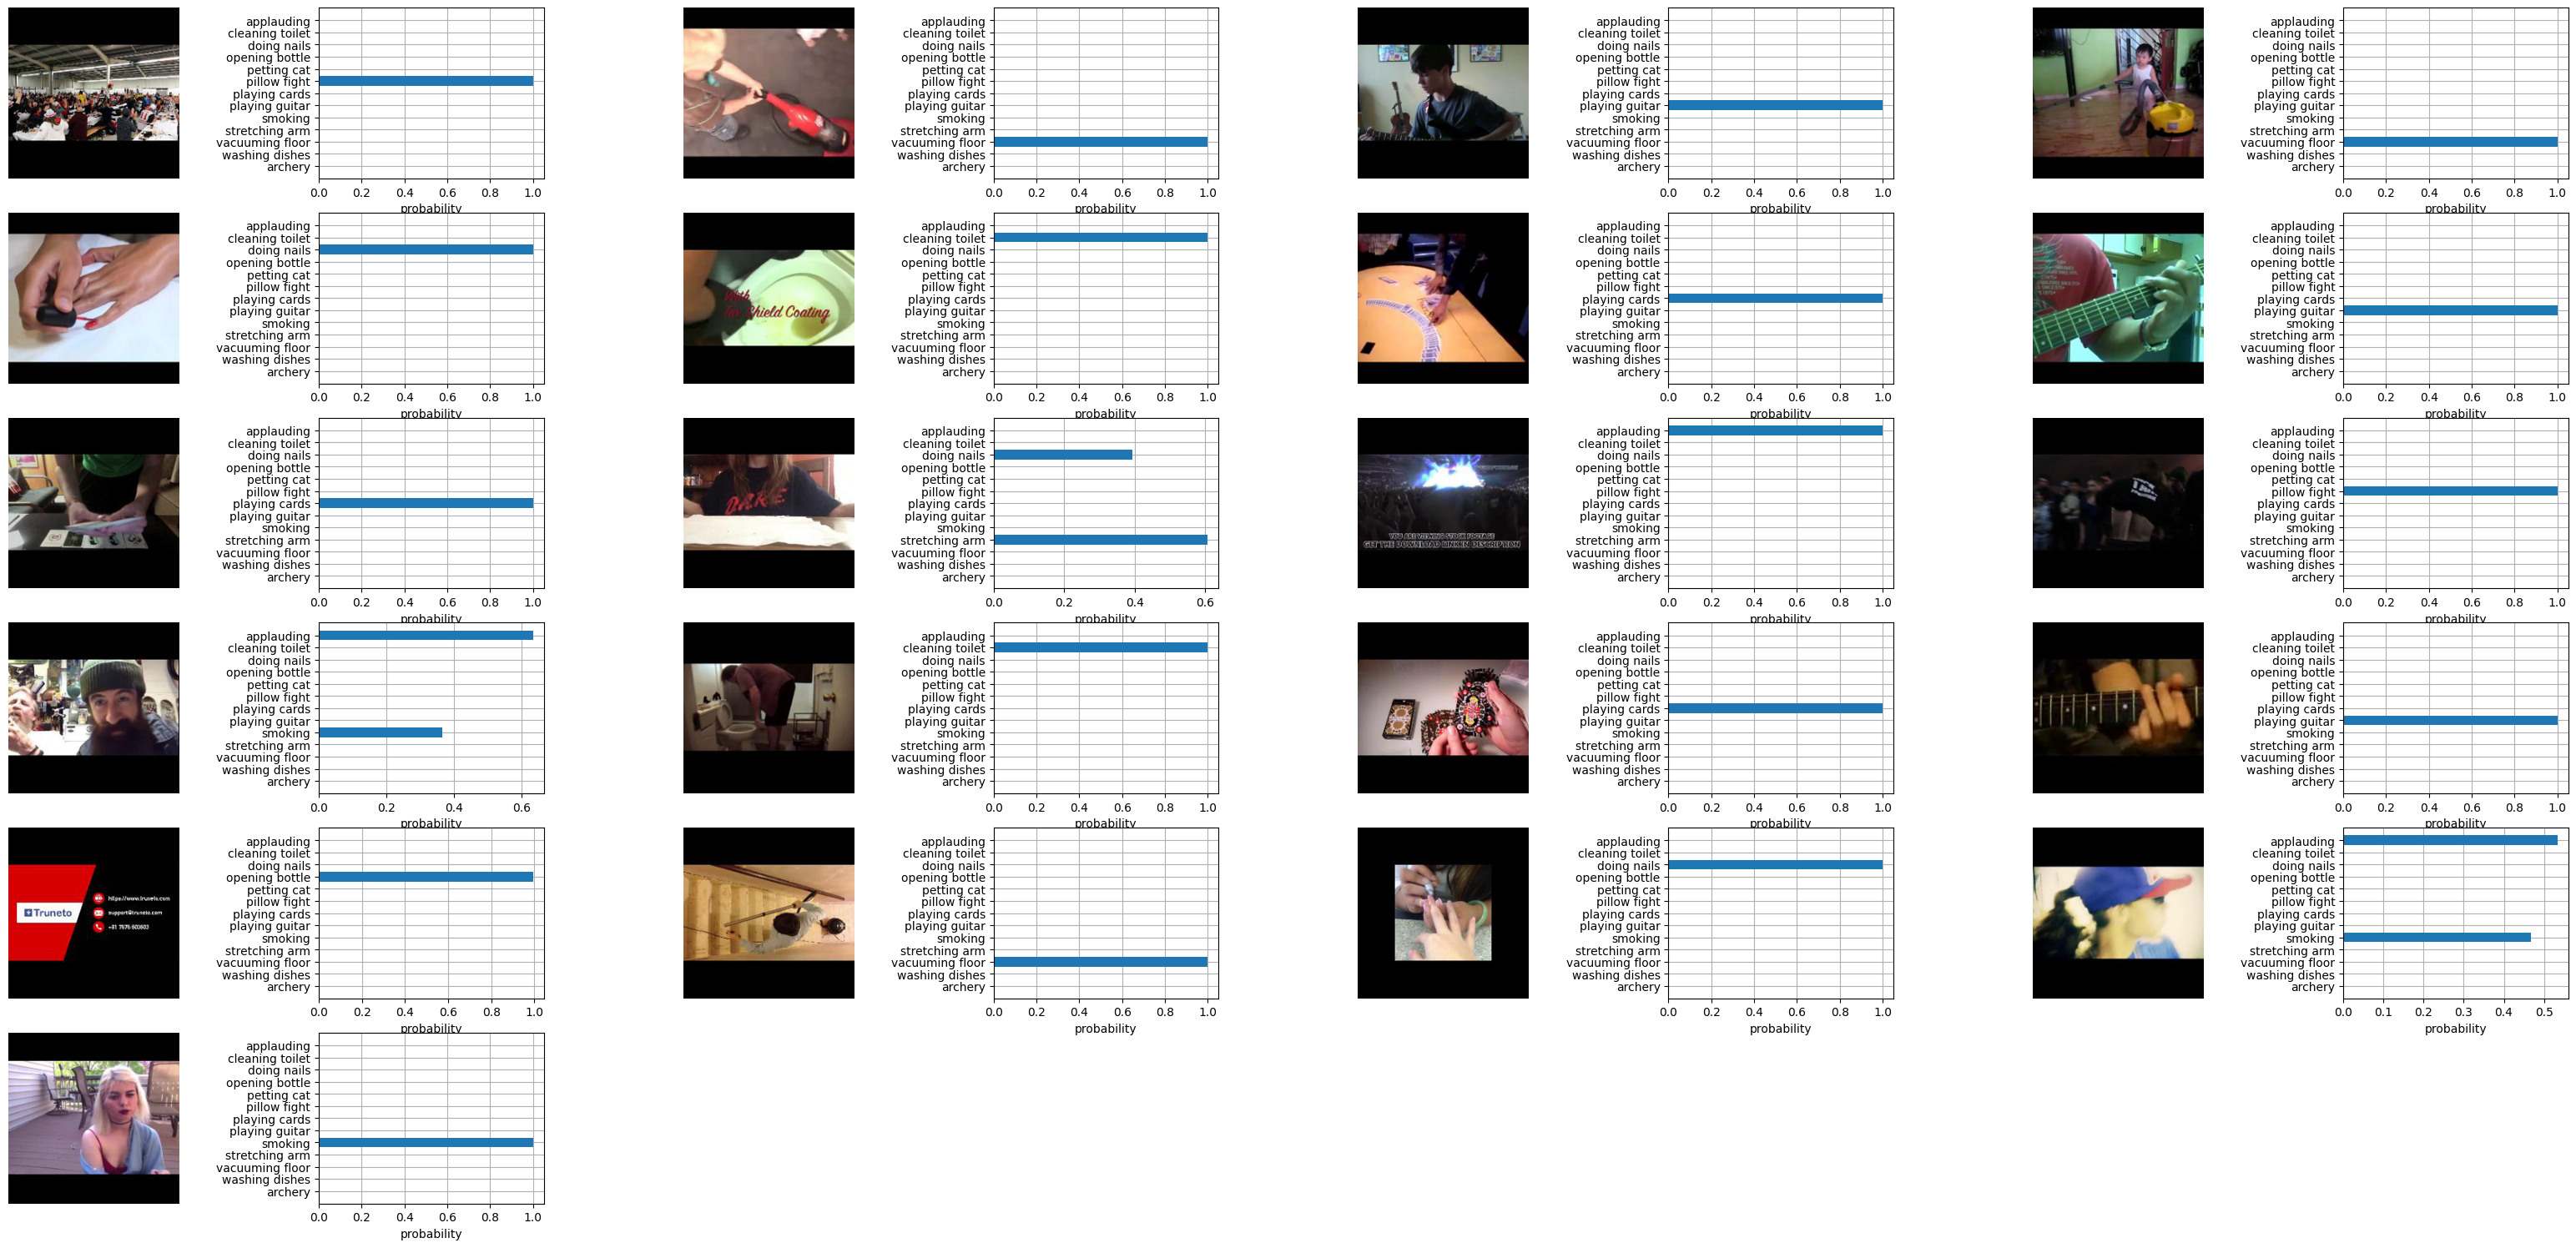

In [ ]:
predict_action(video_names, class_names)

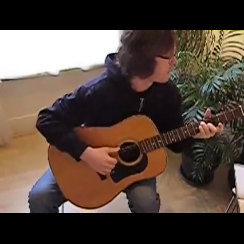

In [ ]:
img = Image.fromarray(sample_video, 'RGB')
img.save('my.png')
img.show()

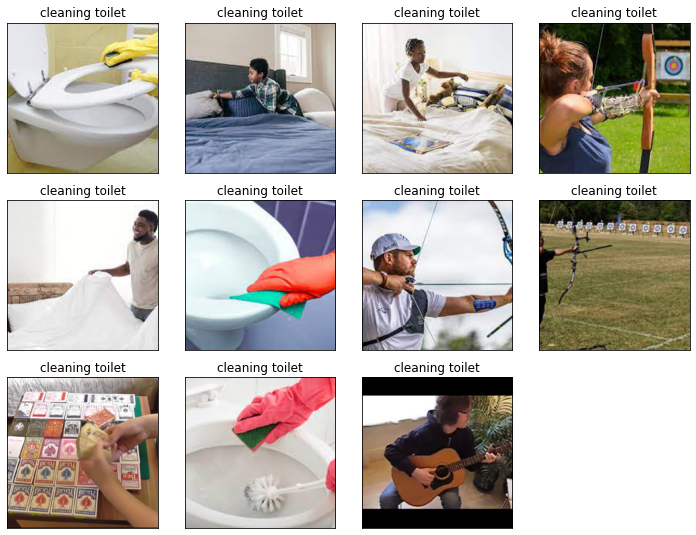

In [ ]:
plt.figure(figsize=(10, 10))

# Show all images from the dataset since our dataset is small
for idx, (image, label_idx) in enumerate(dataset):
    cur_class = class_names[label_idx]    
    
    plt.subplot(4, 4, idx+1)
    plt.imshow(denormalize_image(image).permute(1, 2, 0))
    plt.title(f"{cur_class}")
    plt.xticks([])
    plt.yticks([])

plt.tight_layout()

# Perform classification

Let's perform the classification with our out of the box labels.

In [ ]:
# read out all images and true labels
image_input, y_true = next(iter(data_batches))
image_input = image_input.to(device)

with torch.no_grad():
    image_features = model.encode_image(image_input).float()


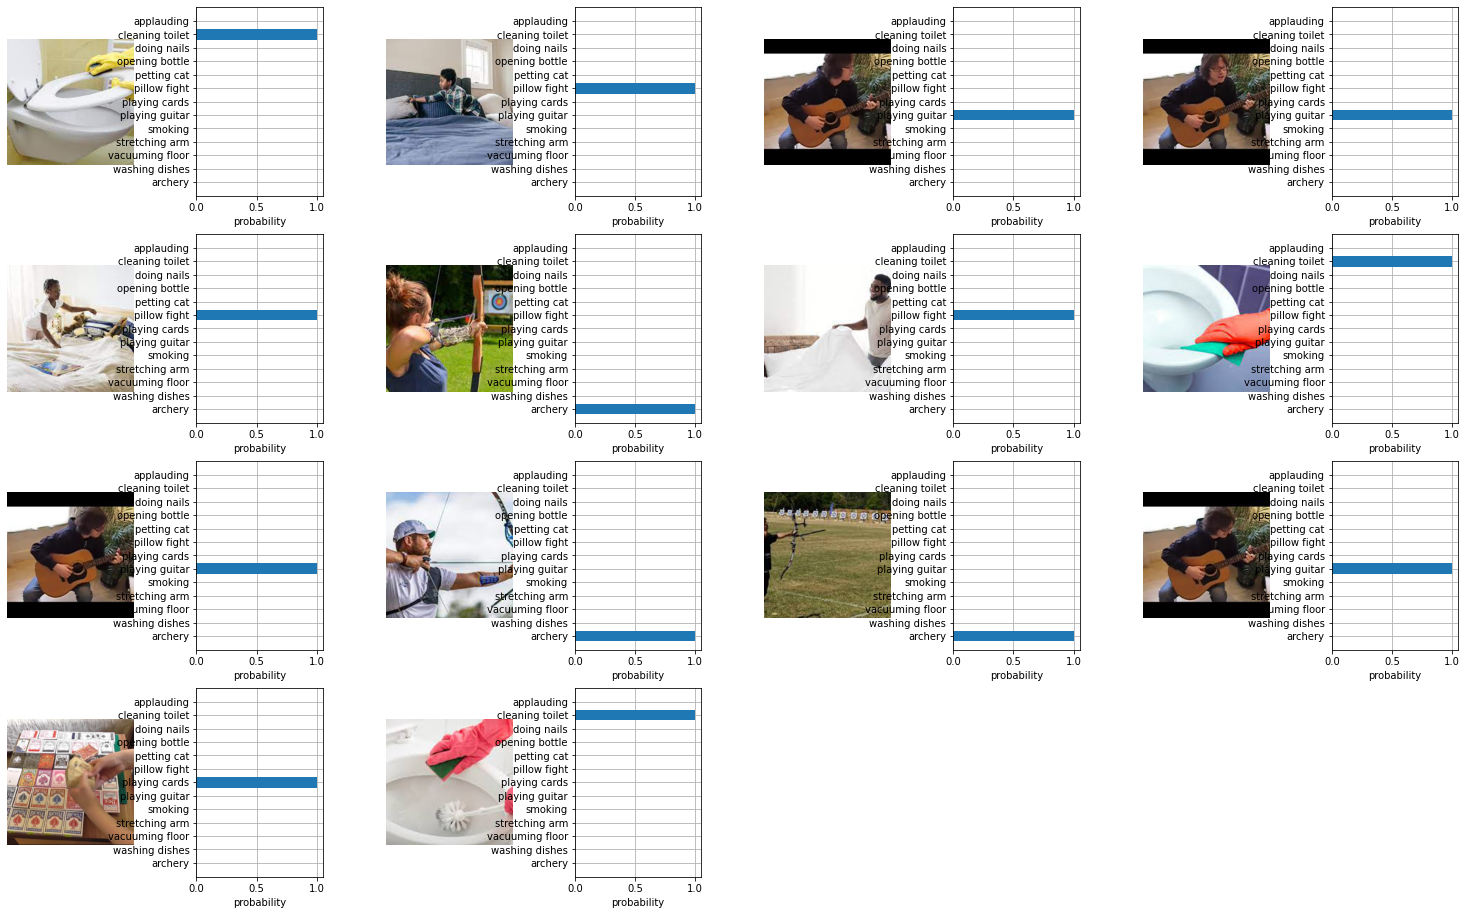

In [ ]:
show_results(image_features, text_features, class_names)

You can see that CLIP is not doing great with these labels.

Let's play with the labels a bit and see if it changes anything.

# Experiments

Below we will try to change lables to see how it affects the results.

## Change names to more common in the US

Let's change names to a more common names in the US. CLIP was supposedly trained on English language corpus and didn't encounter much of Russian names (this is a guess).

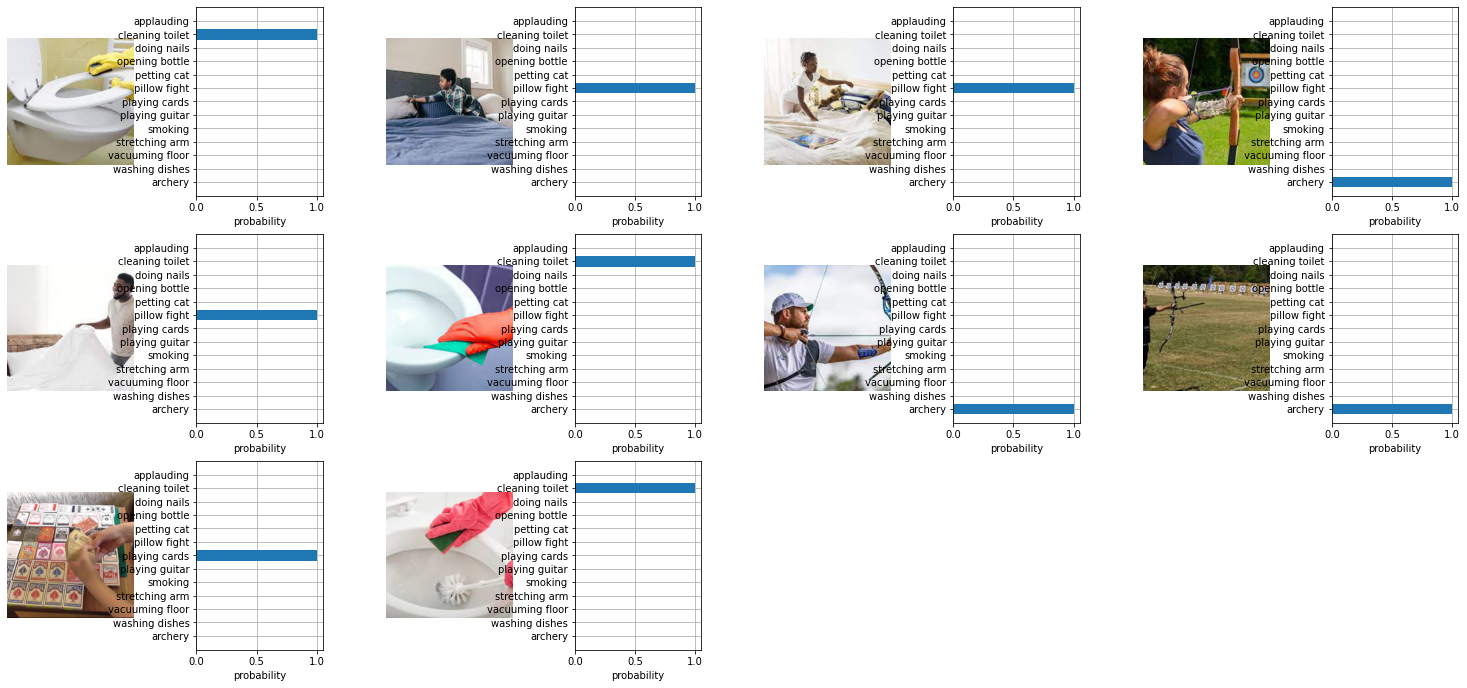

In [ ]:
class_names = ['applauding', 'cleaning toilet', 'doing nails', 'opening bottle', 'petting cat', 'pillow fight', 'playing cards', 'playing guitar', 'smoking', 'stretching arm', 'vacuuming floor', 'washing dishes', 'archery']
class_captions = [f"An image depicting a {x}" for x in class_names]
text_input = clip.tokenize(class_captions).to(device)

with torch.no_grad():
    text_features = model.encode_text(text_input).float()
    text_features /= text_features.norm(dim=-1, keepdim=True)

show_results(image_features, text_features, class_names)

Much, much better!

Looks like we can classify male/female easily. Let's have a look.

## Male/female classification


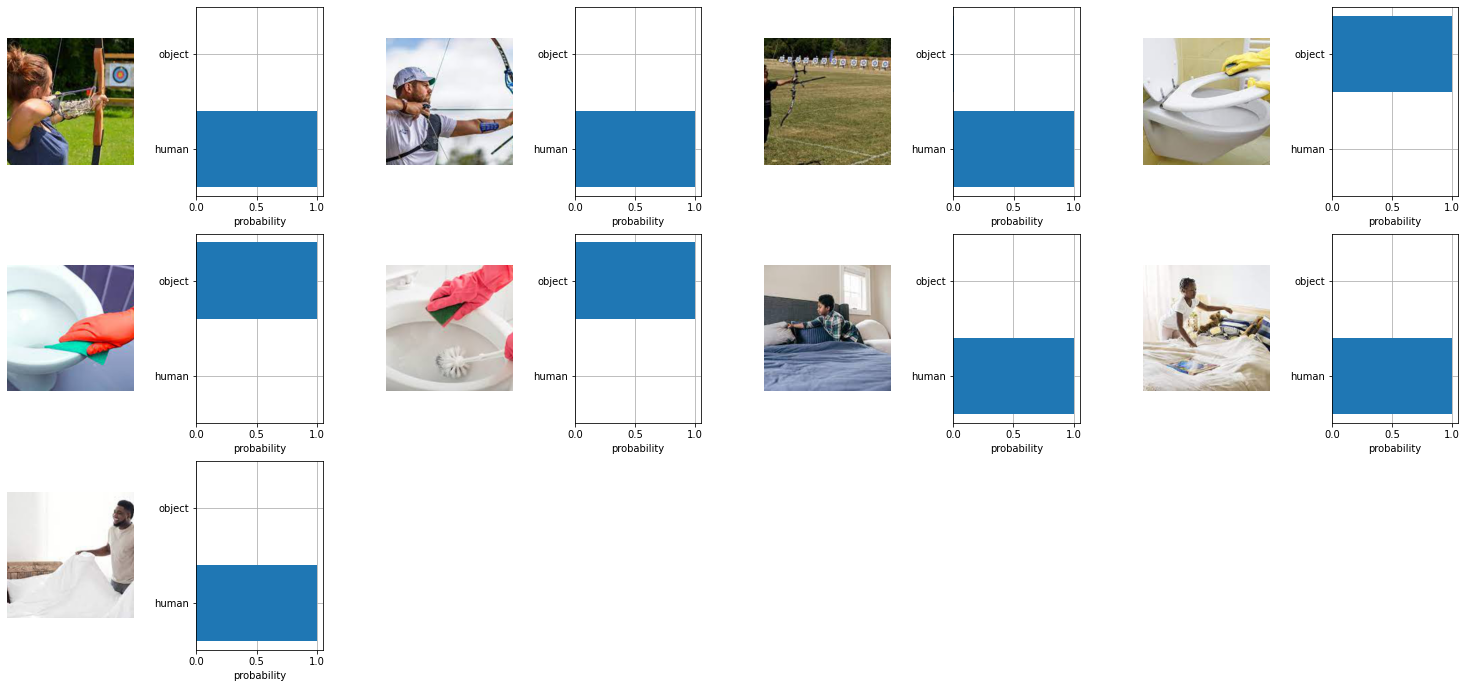

In [ ]:
class_names = ['object', 'human']
class_captions = [f"An image depicting a {x}" for x in class_names]
text_input = clip.tokenize(class_captions).to(device)

with torch.no_grad():
    text_features = model.encode_text(text_input).float()
    text_features /= text_features.norm(dim=-1, keepdim=True)

show_results(image_features, text_features, class_names)

That was pretty accurate. Next step in this direction will be to test it on other ethnicities.

## Object detection/presence?

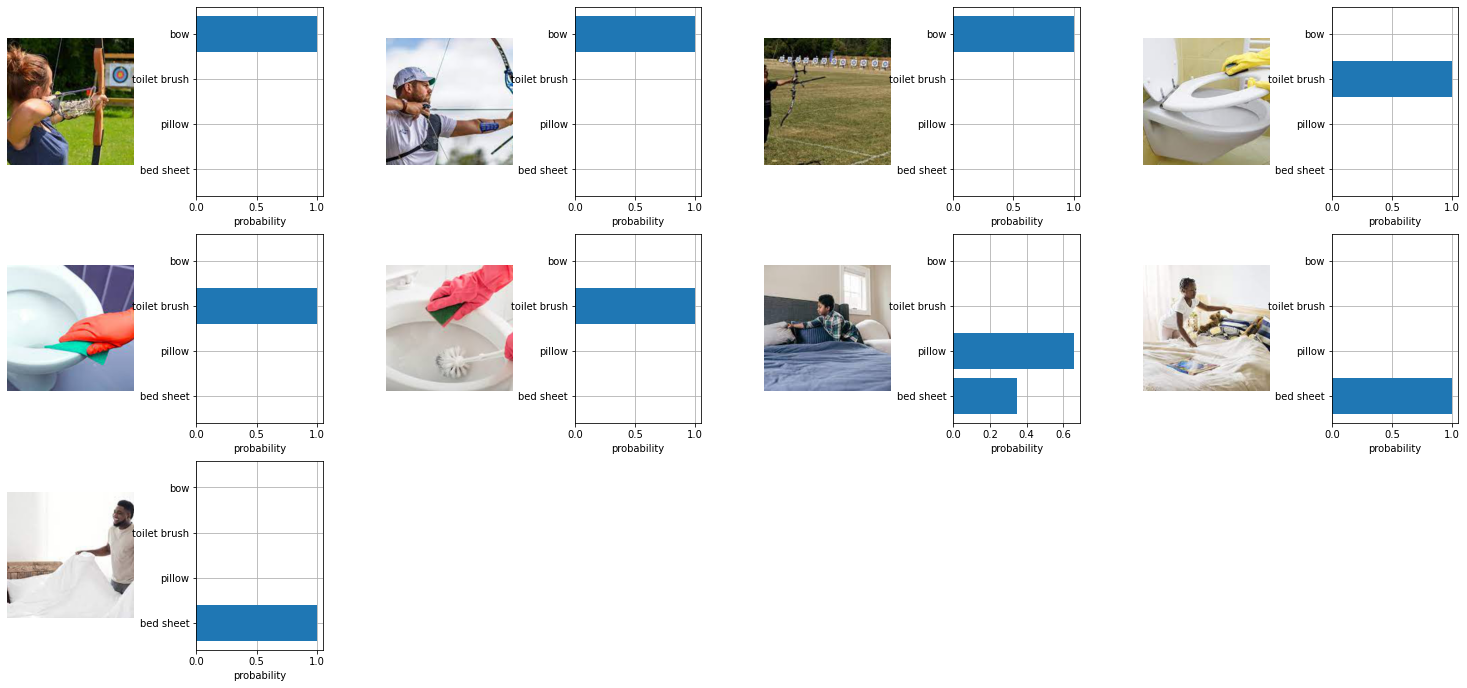

In [ ]:
class_names = ['bow', 'toilet brush', "pillow", "bed sheet"]
class_captions = [f"An image showing a {x}" for x in class_names]
text_input = clip.tokenize(class_captions).to(device)

with torch.no_grad():
    text_features = model.encode_text(text_input).float()
    text_features /= text_features.norm(dim=-1, keepdim=True)

show_results(image_features, text_features, class_names)

## Objects counting by words and digits

Since we have at least one image with two microphones, I wanted to see if CLIP can detect it. We test both variants: `two` and `2`.

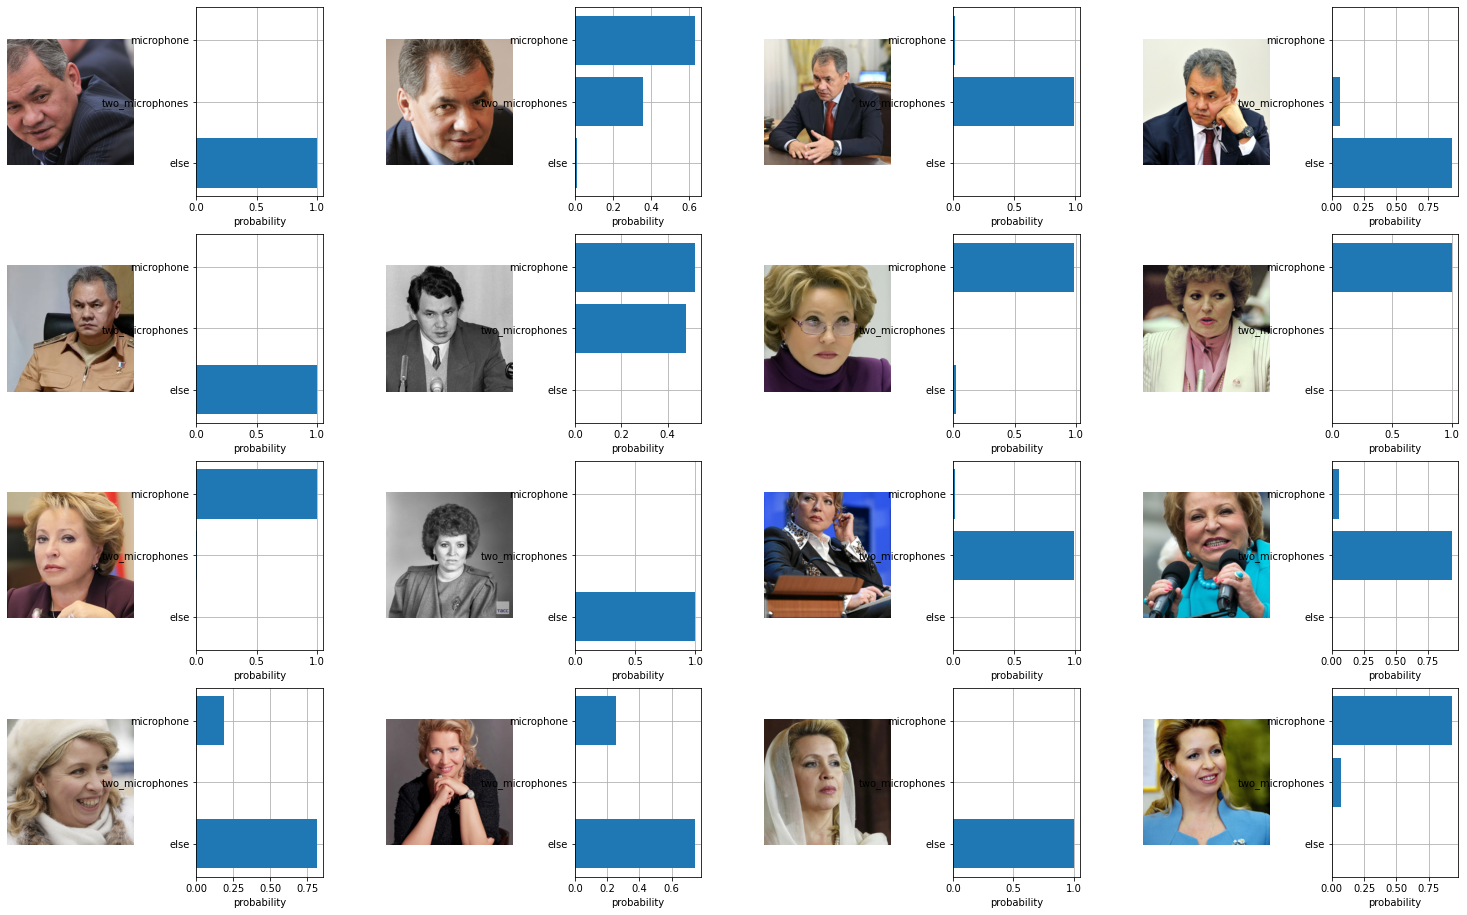

In [ ]:
class_names = ['microphone', 'two_microphones', "else"]
class_captions = ["An image showing a microphone", "An image showing two microphones", "An image showing something else"]
text_input = clip.tokenize(class_captions).to(device)

with torch.no_grad():
    text_features = model.encode_text(text_input).float()
    text_features /= text_features.norm(dim=-1, keepdim=True)

show_results(image_features, text_features, class_names)

We can also see that words description is better than digits-based. Compare above image in row 3 column 4 to the one below:

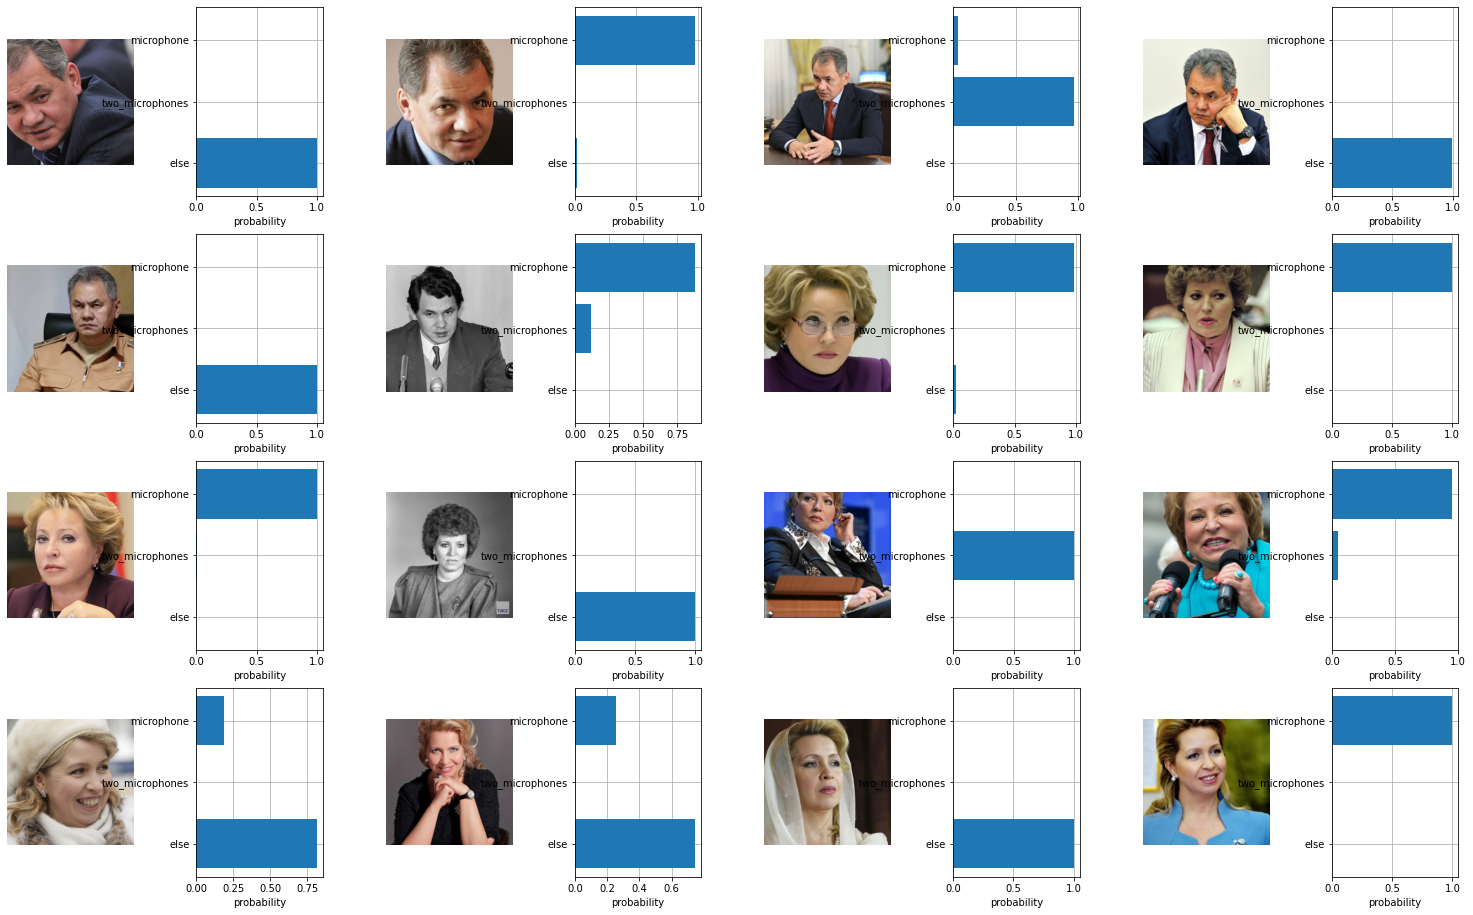

In [ ]:
class_names = ['microphone', 'two_microphones', "else"]
class_captions = ["An image showing a microphone", "An image showing 2 microphones", "An image showing something else"]
text_input = clip.tokenize(class_captions).to(device)

with torch.no_grad():
    text_features = model.encode_text(text_input).float()
    text_features /= text_features.norm(dim=-1, keepdim=True)

show_results(image_features, text_features, class_names)

## Find suitable name for good feature separation

Playing with the names a bit, I found a combination, which allows to distinguish between two females. Combinations that I've tried:

* Sophia, Emma
* Anna, Emma



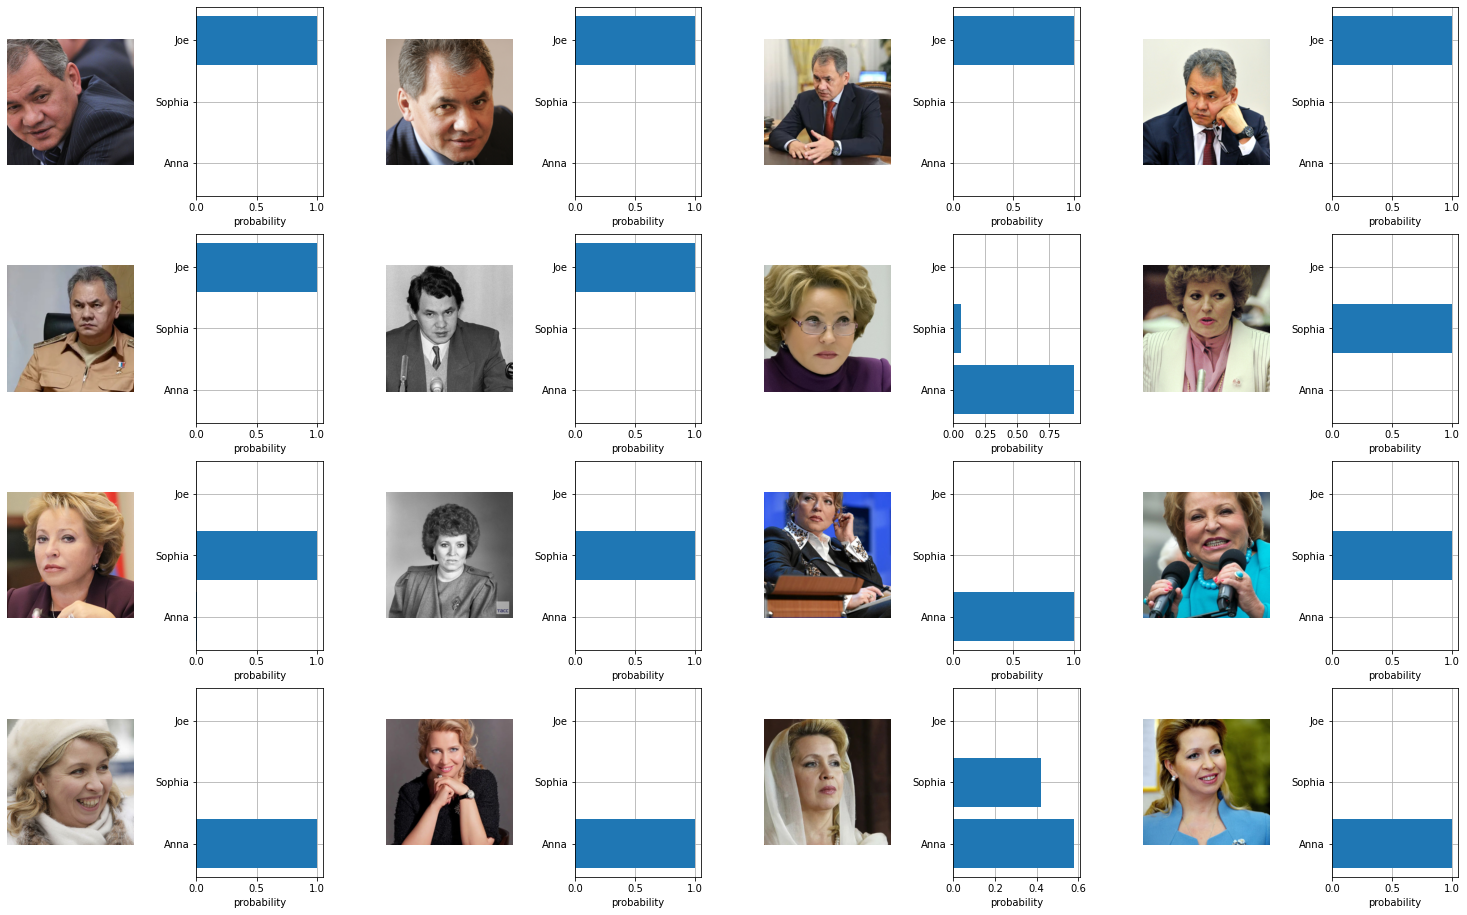

In [ ]:
class_names = ['Joe', 'Sophia', 'Anna']
class_captions = [f"A photo of {x}" for x in class_names]
text_input = clip.tokenize(class_captions).to(device)

with torch.no_grad():
    text_features = model.encode_text(text_input).float()
    text_features /= text_features.norm(dim=-1, keepdim=True)

show_results(image_features, text_features, class_names)

## Add conditions to class descriptions

The idea here is that we add a condition in text description. For this small dataset this is very fragile. The combination bellow works OK, but try to change `Sophia` to something else and the results won't be so good. 

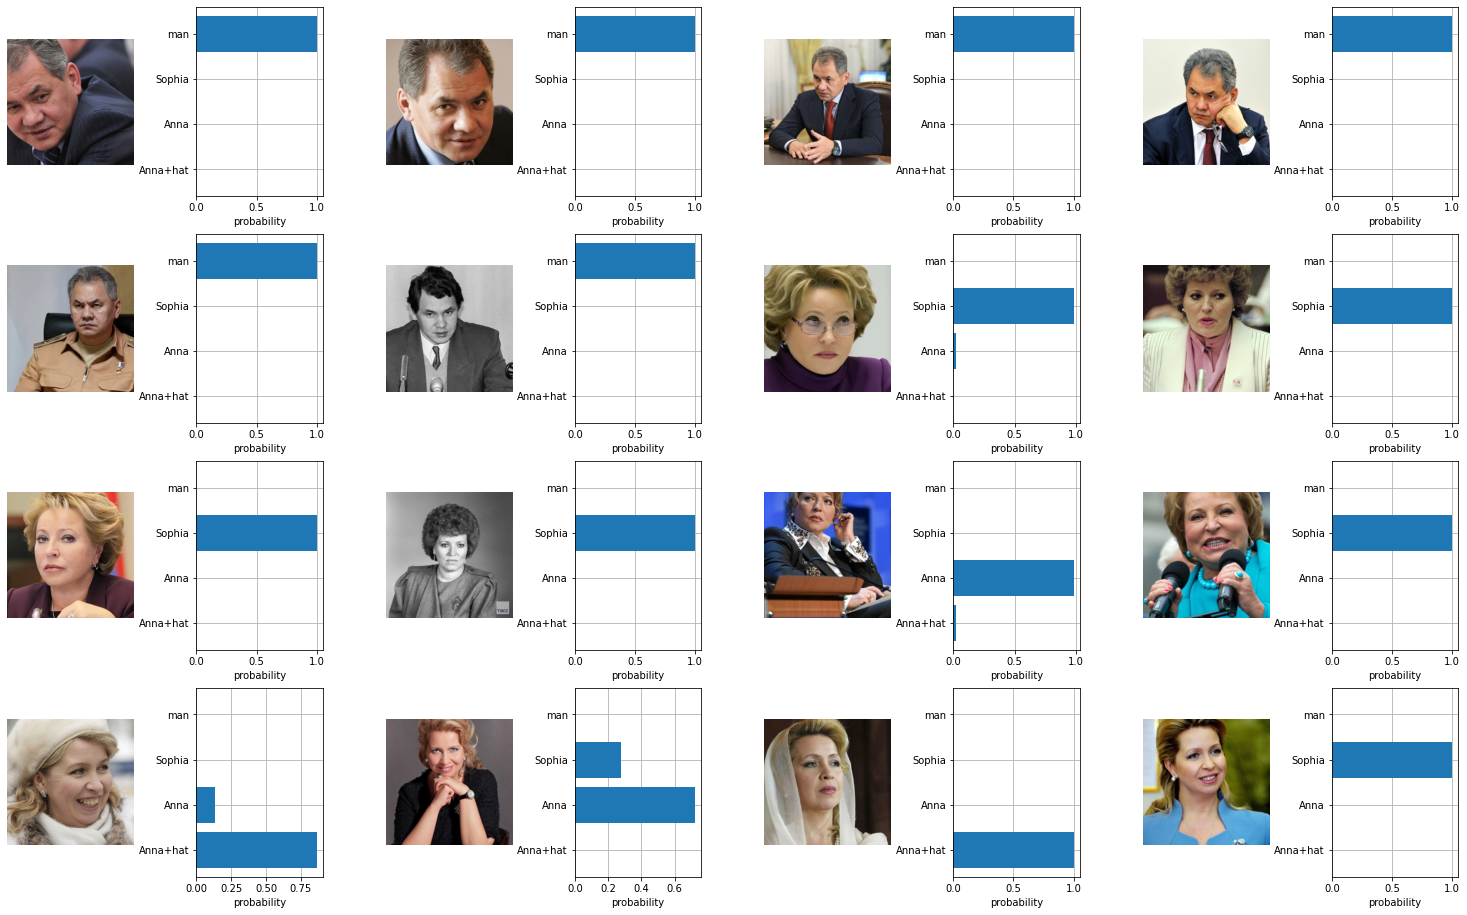

In [ ]:
class_names = ["man", "Sophia", "Anna", "Anna+hat"]
class_captions = ["A photo of a man", "A photo of Sophia", "A photo of a Anna", "A photo of a Anna with head covered"]
text_input = clip.tokenize(class_captions).to(device)

with torch.no_grad():
    text_features = model.encode_text(text_input).float()
    text_features /= text_features.norm(dim=-1, keepdim=True)

show_results(image_features, text_features, class_names)